# Bloc Exploration & Analysis

This notebook explores the Color Pattern Blocs in the Squares public data.

## Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from supabase import create_client, Client

# Load environment variables
load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env.development.local'))

# Set up plotting
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize Supabase
url = os.environ.get('NEXT_PUBLIC_SUPABASE_URL')
key = os.environ.get('NEXT_PUBLIC_SUPABASE_ANON_KEY')
if not url or not key:
    raise ValueError('Missing Supabase credentials')
supabase = create_client(url, key)
print('✅ Setup complete')

✅ Setup complete


## Load Data

In [2]:
# Query public spectrum data
response = supabase.table('public_farcaster_spectrums').select('*').execute()
df = pd.DataFrame(response.data)
print(f'Loaded {len(df)} user spectrums')
print(f'Columns: {list(df.columns)}')
df.head()

Loaded 89 user spectrums
Columns: ['id', 'fid', 'username', 'display_name', 'pfp_url', 'trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score', 'times_updated', 'created_at', 'updated_at', 'divergence_score', 'spread_score']


,id,fid,username,display_name,pfp_url,trade_score,abortion_score,migration_score,economics_score,rights_score,times_updated,created_at,updated_at,divergence_score,spread_score
0,2a1df2ee-b9a4-4d14-8b8a-191d3bbe9460,352478,chronor,chronor,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,1,5,2,3,2,2025-10-19T04:17:30.366141+00:00,2025-10-19T04:18:17.674107+00:00,1.897367,1.720465
1,a0b43a0c-c5ef-4426-8d7a-a01506b0ab3b,392746,0wn,0x0 🎩🔵,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,0,0,0,0,2,2025-10-18T09:58:22.936647+00:00,2025-10-18T09:58:31.269215+00:00,3.000000,0.000000
2,9b53aedd-caea-474a-9c35-1bb9b5288aa5,797945,t9let,T9LET,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,3,4,3,3,0,3,2025-10-18T03:52:37.945627+00:00,2025-10-18T03:55:32.386276+00:00,1.414214,1.356466
3,420ee4d7-8df9-40e0-bb7b-58efdb77b890,284618,brennuet,bren 👁️🪽,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,4,0,0,5,0,2,2025-10-18T03:31:57.595152+00:00,2025-10-18T03:32:03.740194+00:00,2.529822,2.227106
4,1ee9239c-bdc0-48ed-95a3-4b5bc5b9eb7e,250191,ipingo,ipingo.eth,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,5,2,4,3,2,2025-10-18T02:48:57.681623+00:00,2025-10-18T02:49:05.127238+00:00,1.732051,1.720465


## Define Bloc Membership Criteria

In [3]:
# Import bloc configuration
sys.path.append(os.path.dirname(os.getcwd()))
from analytics.bloc_config import BLOC_NAMES, BLOC_DESCRIPTIONS

dimensions = ['trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score']

def get_scores(row):
    return [row[dim] for dim in dimensions]

# BLOC DEFINITIONS
# Rule: ≥3 dimensions in bloc color range
# Color spectrum: 0=purple, 1=blue, 2=green, 3=yellow, 4=orange, 5=red, 6=black

def post_scarcity(row):
    scores = get_scores(row)
    return sum(1 for s in scores if 0 <= s <= 1) >= 3

def builder_bloc(row):
    scores = get_scores(row)
    return sum(1 for s in scores if 1 <= s <= 2) >= 3

def abundance_alliance(row):
    scores = get_scores(row)
    return sum(1 for s in scores if 1 <= s <= 3) >= 3

def localist_league(row):
    scores = get_scores(row)
    return sum(1 for s in scores if 3 <= s <= 5) >= 3

def natcon_corps(row):
    scores = get_scores(row)
    return sum(1 for s in scores if 4 <= s <= 5) >= 3

def postliberal_front(row):
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 5 <= s <= 6)
    very_high = sum(1 for s in scores if s >= 5)
    return in_range >= 3 and very_high >= 2

# Apply memberships
df['post_scarcity'] = df.apply(post_scarcity, axis=1)
df['builder_bloc'] = df.apply(builder_bloc, axis=1)
df['abundance_alliance'] = df.apply(abundance_alliance, axis=1)
df['localist_league'] = df.apply(localist_league, axis=1)
df['natcon_corps'] = df.apply(natcon_corps, axis=1)
df['postliberal_front'] = df.apply(postliberal_front, axis=1)

bloc_columns = list(BLOC_NAMES.keys())
print(f'✅ Bloc memberships calculated ({len(bloc_columns)} blocs)')

✅ Bloc memberships calculated (6 blocs)


## Bloc Membership Distribution

Bloc Membership Counts:\n
                  Bloc  Count  Percentage
    Abundance Alliance     45       50.56
Postscarcity Syndicate     40       44.94
          Builder Bloc     22       24.72
       Localist League     22       24.72
          NatCon Corps      2        2.25
     Postliberal Front      1        1.12
\nUsers in at least one bloc: 82 (92.1%)
Orphaned users: 7 (7.9%)


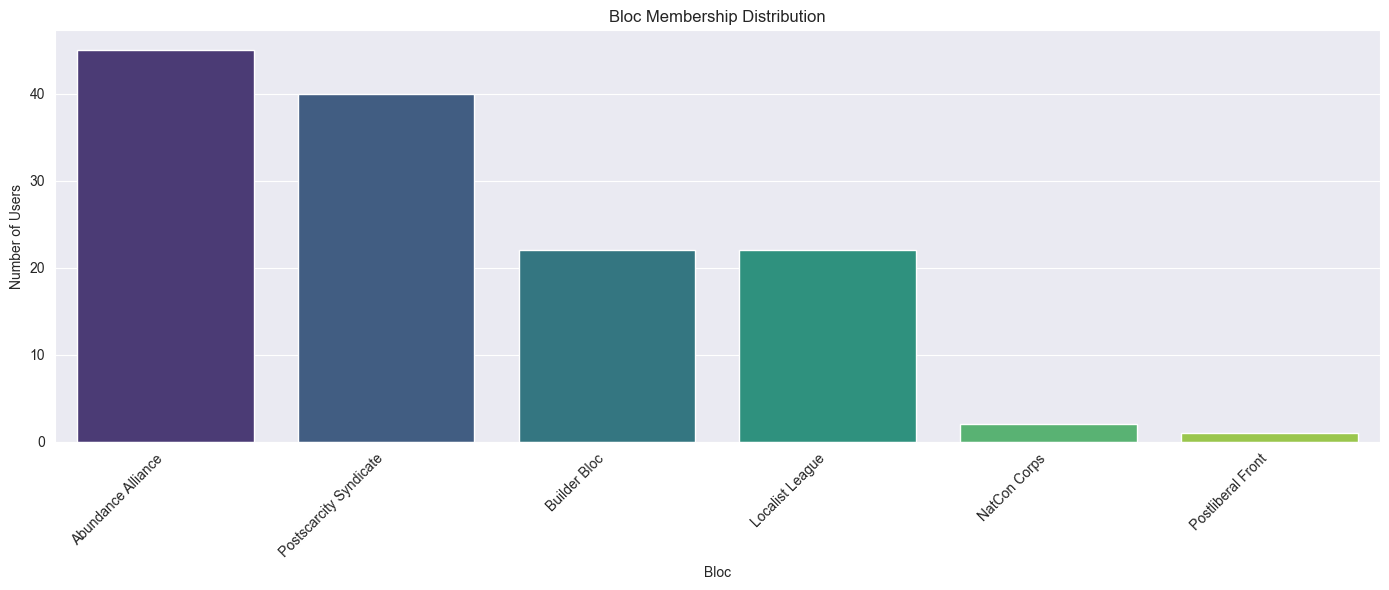

In [4]:
bloc_counts = {BLOC_NAMES[col]: df[col].sum() for col in bloc_columns}
bloc_df = pd.DataFrame(list(bloc_counts.items()), columns=['Bloc', 'Count'])
bloc_df['Percentage'] = (bloc_df['Count'] / len(df) * 100).round(2)
bloc_df = bloc_df.sort_values('Count', ascending=False)

print('Bloc Membership Counts:\\n')
print(bloc_df.to_string(index=False))

# Coverage
df['in_any_bloc'] = df[bloc_columns].any(axis=1)
users_in_bloc = df['in_any_bloc'].sum()
print(f'\\nUsers in at least one bloc: {users_in_bloc} ({users_in_bloc/len(df)*100:.1f}%)')
print(f'Orphaned users: {len(df)-users_in_bloc} ({(len(df)-users_in_bloc)/len(df)*100:.1f}%)')

# Visualize
plt.figure(figsize=(14, 6))
sns.barplot(data=bloc_df, x='Bloc', y='Count', hue='Bloc', palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Bloc Membership Distribution')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

## Bloc Coverage Summary

In [5]:
total_users = len(df)
df['bloc_count'] = df[bloc_columns].sum(axis=1)
orphaned = (~df['in_any_bloc']).sum()
multi_bloc = (df['bloc_count'] > 1).sum()
single_bloc = (df['bloc_count'] == 1).sum()

print("=" * 70)
print("BLOC COVERAGE SUMMARY")
print("=" * 70)
print(f"\\nTotal Users: {total_users}")
print(f"\\nCoverage:")
print(f"  ✓ In at least one bloc: {total_users-orphaned} ({(total_users-orphaned)/total_users*100:.1f}%)")
print(f"  ✗ Orphaned (no bloc): {orphaned} ({orphaned/total_users*100:.1f}%)")
print(f"\\nOverlap:")
print(f"  • Exactly one bloc: {single_bloc} ({single_bloc/total_users*100:.1f}%)")
print(f"  • Multiple blocs: {multi_bloc} ({multi_bloc/total_users*100:.1f}%)")
print(f"  • Max blocs per user: {df['bloc_count'].max()}")

print(f"\\n{'Bloc':<25} {'Members':<10} {'% of Total':<12} {'Avg Blocs/User'}")
print("-" * 70)
for col in bloc_columns:
    bloc_name = BLOC_NAMES[col]
    count = df[col].sum()
    pct = (count / total_users) * 100
    avg_other = df[df[col]]['bloc_count'].mean() if count > 0 else 0
    print(f"{bloc_name:<25} {count:<10} {pct:>6.1f}%      {avg_other:>5.2f}")

print("\\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

orphan_pct = (orphaned / total_users) * 100
if orphan_pct > 20:
    print("\\n⚠️  HIGH ORPHAN RATE: >20% don't fit any bloc")
elif orphan_pct > 10:
    print("\\n⚡ MODERATE ORPHAN RATE: 10-20% don't fit any bloc")
else:
    print("\\n✅ GOOD COVERAGE: <10% orphaned users")

multi_pct = (multi_bloc / total_users) * 100
if multi_pct > 50:
    print("\\n⚠️  HIGH OVERLAP: >50% in multiple blocs")
elif multi_pct > 30:
    print("\\n⚡ MODERATE OVERLAP: 30-50% in multiple blocs")
else:
    print("\\n✅ GOOD EXCLUSIVITY: <30% in multiple blocs")

small_blocs = bloc_df[bloc_df['Count'] < total_users * 0.05]
if len(small_blocs) > 0:
    print(f"\\n⚡ SMALL BLOCS: {len(small_blocs)} bloc(s) <5% membership")

large_blocs = bloc_df[bloc_df['Percentage'] > 40]
if len(large_blocs) > 0:
    print(f"\\n⚡ DOMINANT BLOCS: {len(large_blocs)} bloc(s) >40% membership")

print("\\n" + "=" * 70)

BLOC COVERAGE SUMMARY
\nTotal Users: 89
\nCoverage:
  ✓ In at least one bloc: 82 (92.1%)
  ✗ Orphaned (no bloc): 7 (7.9%)
\nOverlap:
  • Exactly one bloc: 41 (46.1%)
  • Multiple blocs: 41 (46.1%)
  • Max blocs per user: 3
\nBloc                      Members    % of Total   Avg Blocs/User
----------------------------------------------------------------------
Postscarcity Syndicate    40           44.9%       1.57
Builder Bloc              22           24.7%       2.41
Abundance Alliance        45           50.6%       2.07
Localist League           22           24.7%       1.64
NatCon Corps              2             2.2%       2.00
Postliberal Front         1             1.1%       1.00
\n======================================================================
RECOMMENDATIONS
\n✅ GOOD COVERAGE: <10% orphaned users
\n⚡ MODERATE OVERLAP: 30-50% in multiple blocs
\n⚡ SMALL BLOCS: 2 bloc(s) <5% membership
\n⚡ DOMINANT BLOCS: 2 bloc(s) >40% membership
\n======================================

## Orphaned Users Analysis

Orphaned Users: 7 (7.9%)
\nOrphaned users:
  @kingmodaser: T=3, A=0, M=0, E=4, R=6
  @biggals: T=0, A=1, M=6, E=4, R=2
  @oladotun: T=1, A=6, M=6, E=3, R=0
  @tapjoy: T=1, A=4, M=6, E=0, R=3
  @tohpac1: T=0, A=1, M=2, E=5, R=4
  @wayseeker: T=4, A=2, M=0, E=4, R=0
  @azbest: T=4, A=0, M=2, E=4, R=0
\nOrphaned User Statistics:
------------------------------------------------------------
Trade           Avg: 1.86
Abortion        Avg: 2.00
Migration       Avg: 3.14
Economics       Avg: 3.43
Rights          Avg: 2.14


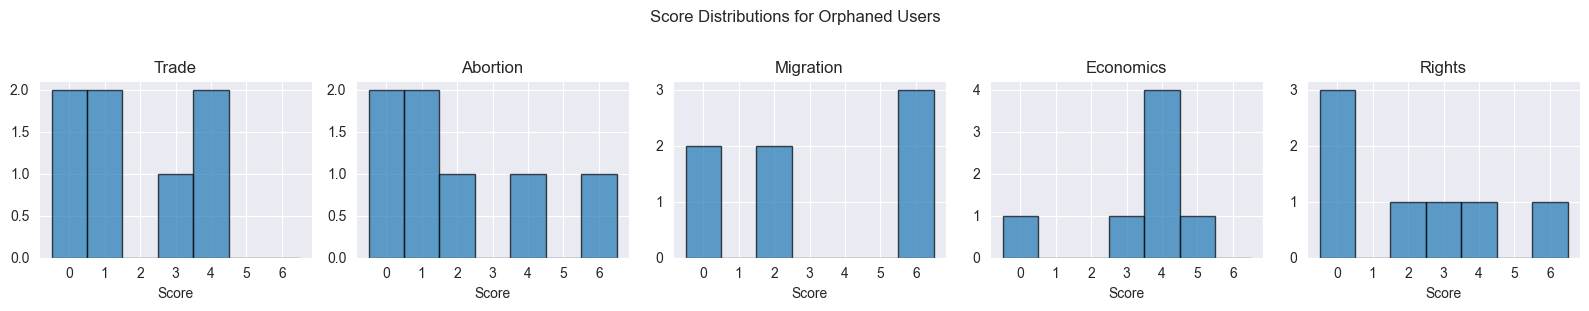

In [6]:
orphaned = df[~df['in_any_bloc']].copy()

print(f"Orphaned Users: {len(orphaned)} ({len(orphaned)/len(df)*100:.1f}%)")
print("="*70)

if len(orphaned) > 0:
    print(f"\\nOrphaned users:")
    for idx, row in orphaned.iterrows():
        print(f"  @{row['username']}: T={row['trade_score']}, A={row['abortion_score']}, M={row['migration_score']}, E={row['economics_score']}, R={row['rights_score']}")
    
    print(f"\\nOrphaned User Statistics:")
    print("-" * 60)
    for dim in dimensions:
        print(f"{dim.replace('_score', '').title():<15} Avg: {orphaned[dim].mean():.2f}")
    
    # Distribution
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    for idx, dim in enumerate(dimensions):
        axes[idx].hist(orphaned[dim], bins=7, range=(-0.5, 6.5), alpha=0.7, edgecolor='black')
        axes[idx].set_title(dim.replace('_score', '').title())
        axes[idx].set_xlabel('Score')
        axes[idx].set_xticks(range(7))
    plt.suptitle('Score Distributions for Orphaned Users', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\\n✅ No orphaned users!")

## Bloc Overlap Analysis

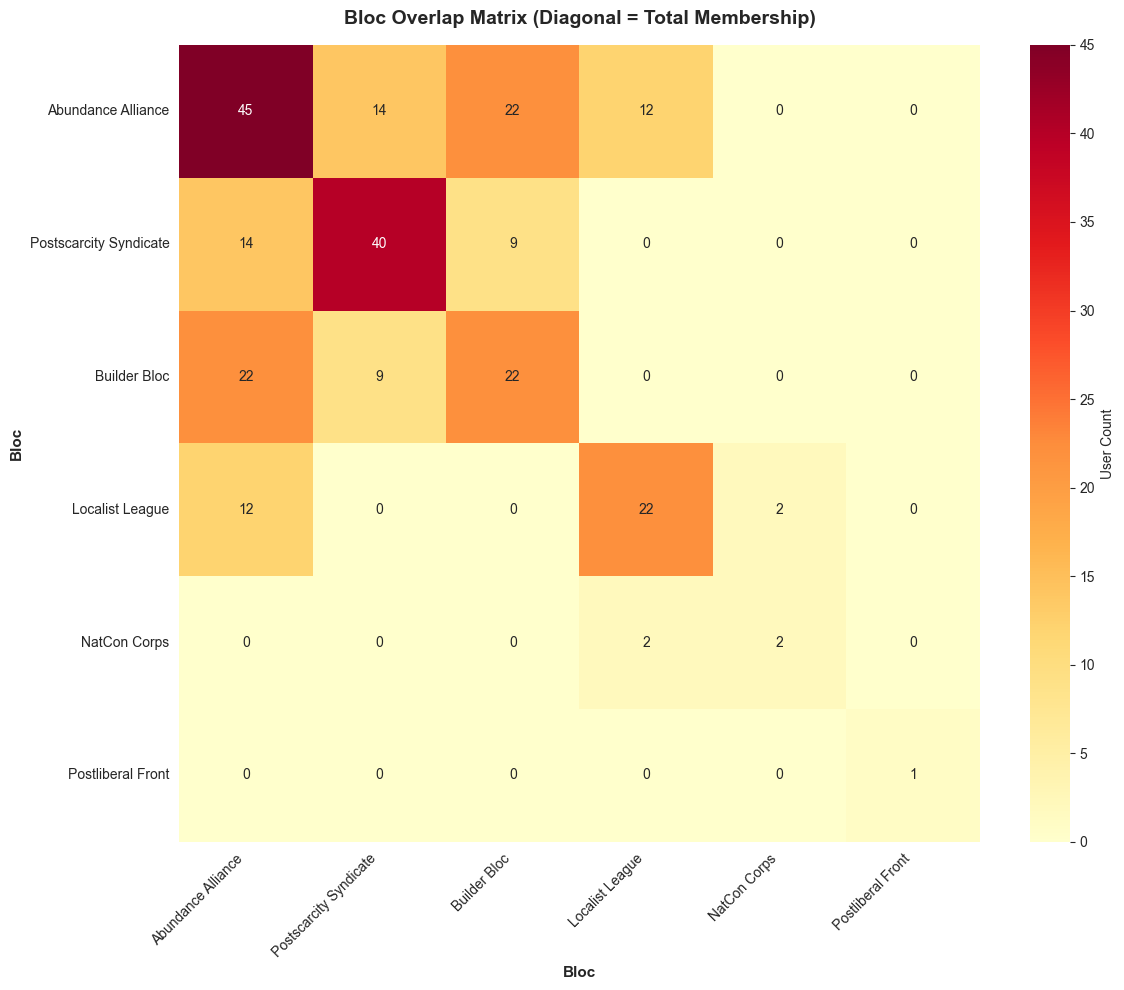

In [7]:
# Create overlap matrix
overlap_matrix = pd.DataFrame(index=bloc_df['Bloc'], columns=bloc_df['Bloc'], dtype=int)

for bloc1_id, bloc1_name in BLOC_NAMES.items():
    for bloc2_id, bloc2_name in BLOC_NAMES.items():
        if bloc1_name == bloc2_name:
            overlap_matrix.loc[bloc1_name, bloc2_name] = df[bloc1_id].sum()
        else:
            overlap_matrix.loc[bloc1_name, bloc2_name] = (df[bloc1_id] & df[bloc2_id]).sum()

overlap_matrix = overlap_matrix.astype(int)

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'User Count'})
plt.title('Bloc Overlap Matrix (Diagonal = Total Membership)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Bloc', fontsize=11, fontweight='bold')
plt.ylabel('Bloc', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Bloc System Quality Report

In [8]:
# Prepare data
df['blocs'] = df.apply(lambda row: [BLOC_NAMES[col] for col in bloc_columns if row[col]], axis=1)

orphaned_count = (~df['in_any_bloc']).sum()
users_in_any_bloc = df['in_any_bloc'].sum()
exclusive_users = (df['bloc_count'] == 1).sum()
multi_bloc_users = (df['bloc_count'] > 1).sum()

print("="*70)
print("BLOC SYSTEM QUALITY REPORT")
print("="*70)

coverage_rate = (users_in_any_bloc / total_users) * 100
avg_memberships = df['blocs'].apply(len).mean()

print(f"\\n📊 Coverage Metrics:")
print(f"   • Total users: {total_users:,}")
print(f"   • In at least one bloc: {users_in_any_bloc:,} ({coverage_rate:.1f}%)")
print(f"   • Orphaned: {orphaned_count:,} ({orphaned_count/total_users*100:.1f}%)")

print(f"\\n🎯 Coherence Metrics:")
print(f"   • Avg blocs per member: {avg_memberships:.2f}")
print(f"   • Exclusive members (1 bloc): {exclusive_users:,} ({exclusive_users/users_in_any_bloc*100:.1f}%)")
print(f"   • Multi-bloc members: {multi_bloc_users:,} ({multi_bloc_users/users_in_any_bloc*100:.1f}%)")

quality_score = (coverage_rate * 0.4) + ((exclusive_users / users_in_any_bloc * 100) * 0.3) + ((users_in_any_bloc / total_users * 100) * 0.3)

print(f"\\n⭐ Overall Quality Score: {quality_score:.1f}/100")
print(f"   (40% coverage + 30% exclusivity + 30% capture)")
print("\\n" + "="*70)

BLOC SYSTEM QUALITY REPORT
\n📊 Coverage Metrics:
   • Total users: 89
   • In at least one bloc: 82 (92.1%)
   • Orphaned: 7 (7.9%)
\n🎯 Coherence Metrics:
   • Avg blocs per member: 1.48
   • Exclusive members (1 bloc): 41 (50.0%)
   • Multi-bloc members: 41 (50.0%)
\n⭐ Overall Quality Score: 79.5/100
   (40% coverage + 30% exclusivity + 30% capture)
\n======================================================================


## Visualization Dashboard

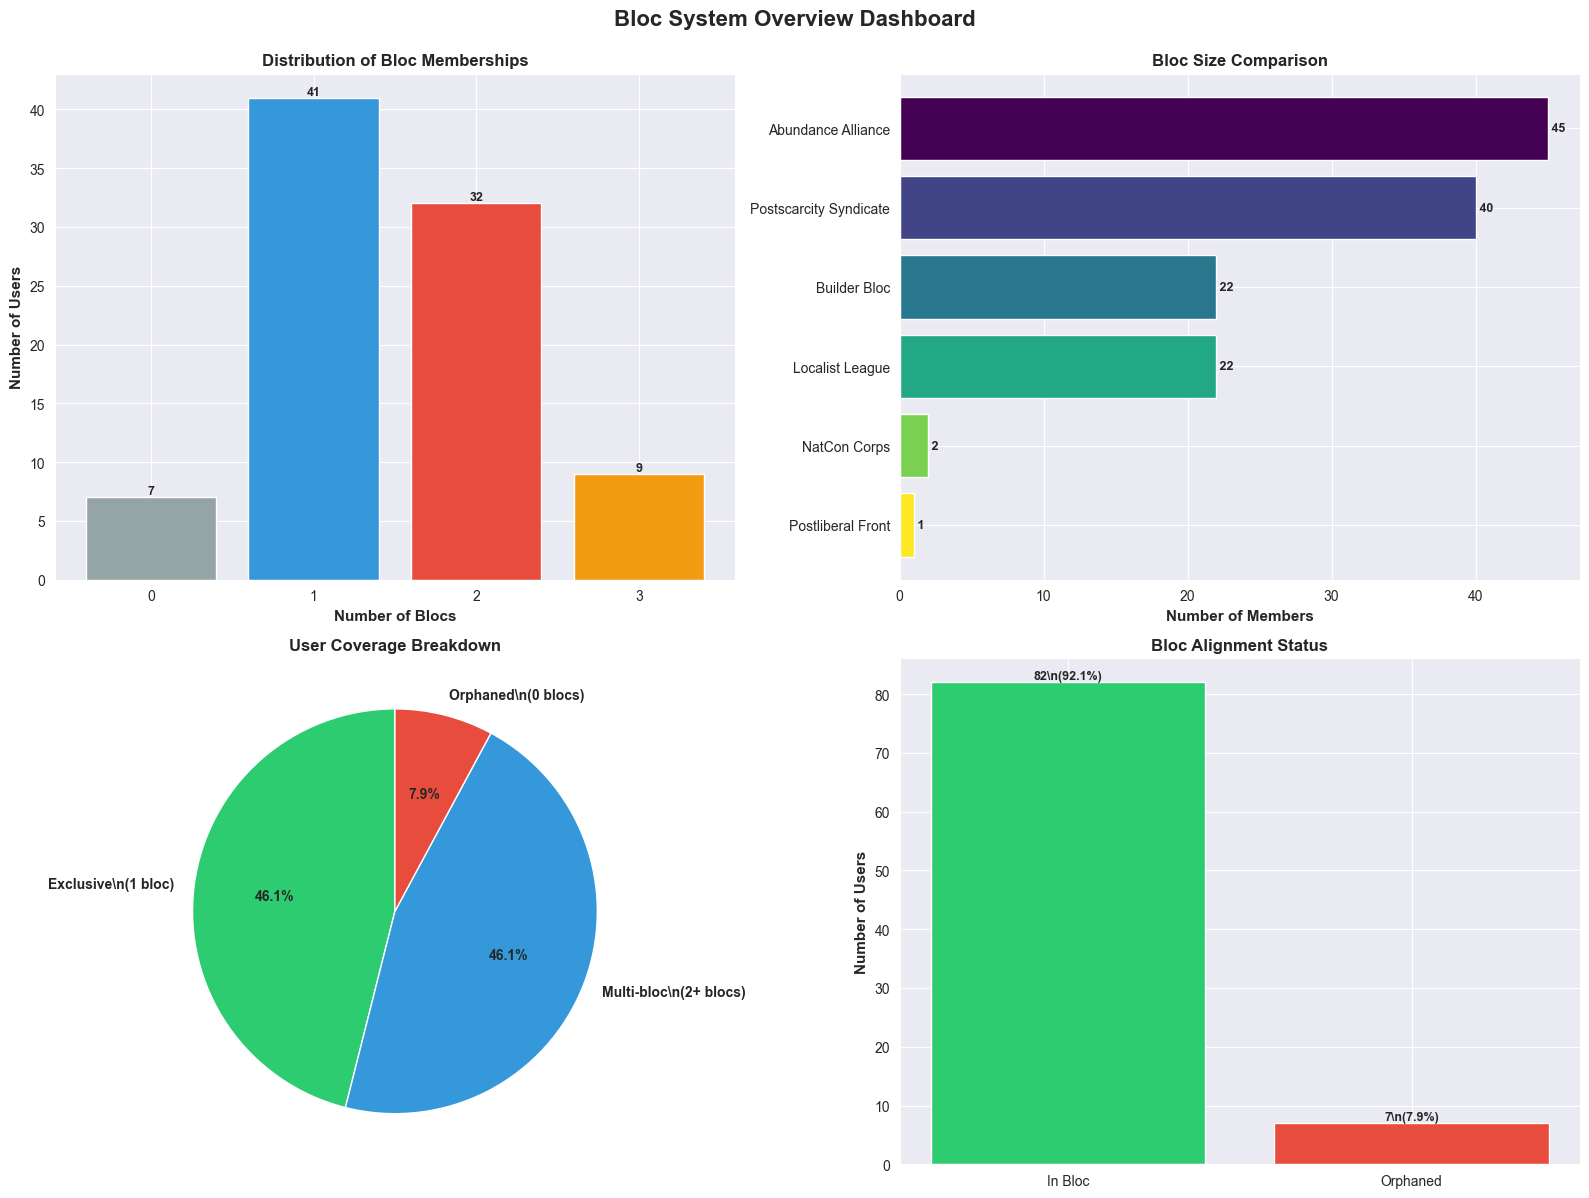

\n✅ Bloc exploration complete!


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Membership count distribution
membership_counts = df['blocs'].apply(len).value_counts().sort_index()
ax1 = axes[0, 0]
bars = ax1.bar(membership_counts.index, membership_counts.values, color=['#95a5a6', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#2ecc71'])
ax1.set_xlabel('Number of Blocs', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Bloc Memberships', fontsize=12, fontweight='bold')
ax1.set_xticks(range(0, max(membership_counts.index) + 1))
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Bloc size comparison
ax2 = axes[0, 1]
colors_bar = plt.cm.viridis(np.linspace(0, 1, len(bloc_df)))
bars = ax2.barh(bloc_df['Bloc'], bloc_df['Count'], color=colors_bar)
ax2.set_xlabel('Number of Members', fontsize=11, fontweight='bold')
ax2.set_title('Bloc Size Comparison', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2., f' {int(width):,}', ha='left', va='center', fontsize=9, fontweight='bold')

# 3. Coverage breakdown (pie)
ax3 = axes[1, 0]
coverage_data = {'Exclusive\\n(1 bloc)': exclusive_users, 'Multi-bloc\\n(2+ blocs)': multi_bloc_users, 'Orphaned\\n(0 blocs)': orphaned_count}
colors_pie = ['#2ecc71', '#3498db', '#e74c3c']
ax3.pie(coverage_data.values(), labels=coverage_data.keys(), autopct='%1.1f%%', colors=colors_pie, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('User Coverage Breakdown', fontsize=12, fontweight='bold')

# 4. Alignment status
ax4 = axes[1, 1]
alignment_data = {'In Bloc': users_in_any_bloc, 'Orphaned': orphaned_count}
colors_align = ['#2ecc71', '#e74c3c']
bars = ax4.bar(range(len(alignment_data)), alignment_data.values(), color=colors_align)
ax4.set_xticks(range(len(alignment_data)))
ax4.set_xticklabels(alignment_data.keys(), fontsize=10)
ax4.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax4.set_title('Bloc Alignment Status', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}\\n({height/total_users*100:.1f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Bloc System Overview Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\\n✅ Bloc exploration complete!")